In [14]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json
%matplotlib inline
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression



pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?
- These are websites that always relevant like recipies or reviews (as opposed to current events)
- Look at some examples

In [4]:
data = pd.read_csv('train.csv', sep='\t', na_values='?')

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', '')).fillna('')
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', '')).fillna('')

In [5]:
data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


#### In previous lessons, we added text features manually as below 

In [19]:
data['recipe'] = data['title'].str.lower().str.contains('recipe')
data['electronic'] = data['title'].str.lower().str.contains('electronic')
data['tips'] = data['title'].str.lower().str.contains('tips')

data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body,recipe,electronic,tips
0,http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html,4042,"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1.0,1,24,0.0,5424,170,8,0.152941,0.079130,0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose Califor...,False,False,False
1,http://www.popsci.com/technology/article/2012-07/electronic-futuristic-starting-gun-eliminates-advantages-races,8471,"{""title"":""The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races"",""body"":""And that can be carried on a pla...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1.0,1,40,0.0,4973,187,9,0.181818,0.125448,1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",And that can be carried on a plane without the hassle too The Omega E Gun Starting Pistol Omega It s easy to take for granted just how insanely close some Olympic races are and how much the minutiae of it all can matter The perfect example is the traditional starting gun Seems easy You pull a tr...,False,True,False
2,http://www.menshealth.com/health/flu-fighting-fruits?cm_mmc=Facebook-_-MensHealth-_-Content-Health-_-FightFluWithFruit,1164,"{""title"":""Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health"",""body"":""Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent hea...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1.0,1,55,0.0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick ...,False,False,False
3,http://www.dumblittleman.com/2007/12/10-foolproof-tips-for-better-sleep.html,6684,"{""title"":""10 Foolproof Tips for Better Sleep "",""body"":""There was a period in my life when I had a lot of problems with sleep It took me very long to fall asleep I was easily awaken and I simply wasn t getting enough of rest at night I didn t want to take medication and this led me to learn sever...",health,0.801248,1.543103,0.400000,0.1000

#### We can build a Logistic Regression model using scikit-learn and examine the coefficients
- Examine the coefficients using the `examine_coefficients` function provided

In [18]:
def examine_coefficients(model, df):
    df = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')
    return df[df.Coefficient !=0 ]


In [24]:
from sklearn.linear_model import LogisticRegression

#Assigning input data for model
X = data[['recipe','electronic','tips']]
#Assigning output data for model
y = data.label

model = LogisticRegression() 

model.fit(X, y) # This fits the model to learn the coefficients

examine_coefficients(model, X)



[[ 2.48284918 -0.44172111  0.62025012]]


,Coefficient,Feature
1,-0.441721,electronic
2,0.620250,tips
0,2.482849,recipe


#### We can build text features in bulk as well using built-in preprocessing tools
- `CountVectorizer` builds a feature per word automatically as we did manually for `recipe`, `electronic` above.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=50, # Only use the top 50 most common words
)


# This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
X = v.fit_transform(data.title).todense()
X = pd.DataFrame(X, columns=v.get_feature_names())
X.head()

,10,2011,allrecipes,apple,baked,best,blog,butter,cake,cheese,chicken,chocolate,com,cookies,cooking,cream,cupcakes,day,easy,fashion,food,foods,free,health,healthy,home,homemade,illustrated,insidershealth,kitchen,life,make,new,news,peanut,photos,pie,recipe,recipes,si,sports,style,sweet,swimsuit,technology,time,tips,video,ways,world
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Using the input matrix above, fit a logistic regression model using L1 regularization
- Change the `C` parameter
    - how do the coefficients change? (use `examine_coeffcients`)
    - how does the model perfomance change (using AUC)

/Users/Madballa55/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


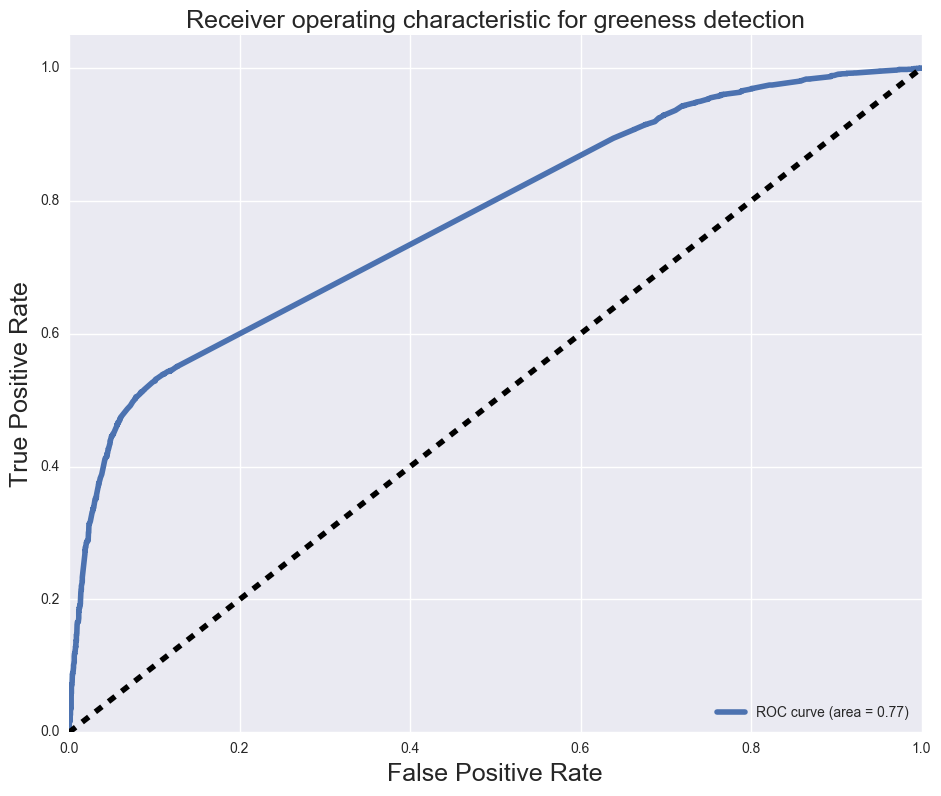

mean accuracy: 0.706965339285, all: [ 0.69870235  0.7148073   0.70738636]
mean precision: 0.836473591434, all: [ 0.81468111  0.84691358  0.84782609]
mean recall: 0.533719432112, all: [ 0.53475513  0.54229249  0.52411067]
mean roc_auc: 0.766074760349, all: [ 0.7641716   0.77044433  0.76360834]


In [26]:

# TODO
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt

#Sets the penalty and C value for the model (higher C = less alpha = less regularization, penalty = l1(one) which is a lasso regression)
model = LogisticRegression(penalty = 'l1', C = 15)

#Creates model
model.fit(X, y)
#Shows coefficient per X
examine_coefficients(model, X)
# Assigns output
Y_Predictions = model.predict_proba(X)

#Creates FPR and TPR per threshold (index) by comparing y (actual) at different thresholds (% probability we will make output 1/0)
FPR, TPR, thresholds = roc_curve(y, Y_Predictions[:,1])

ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for greeness detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Displays accuracy of model
for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

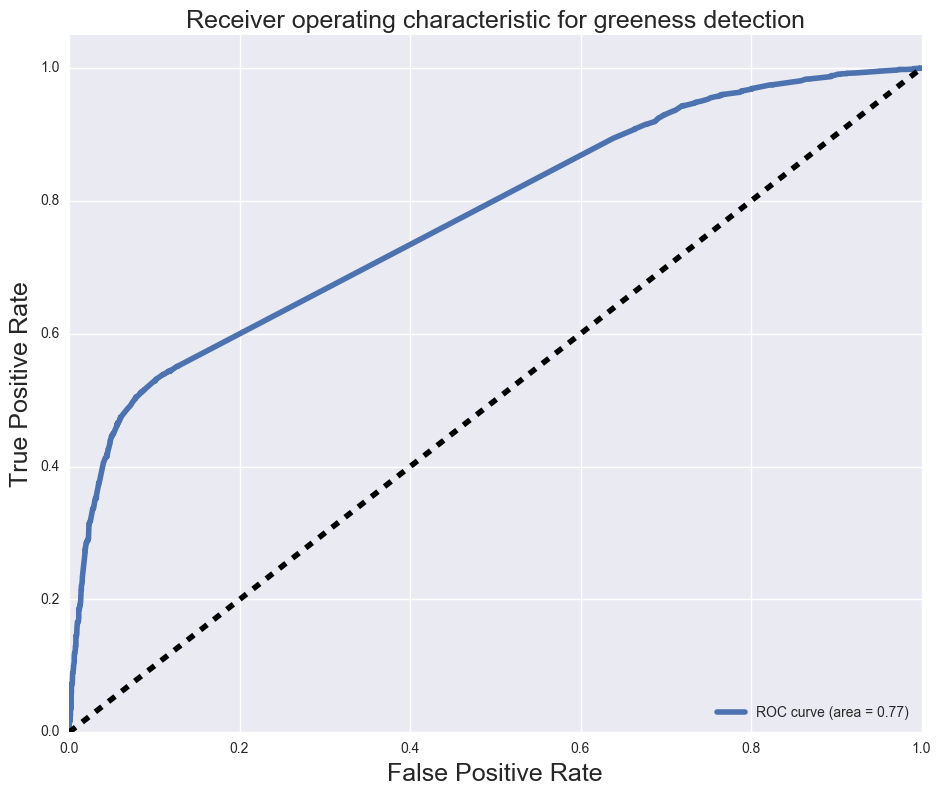

mean accuracy: 0.70710062067, all: [ 0.69870235  0.7148073   0.70779221]
mean precision: 0.836538373858, all: [ 0.81468111  0.84691358  0.84802043]
mean recall: 0.533982936724, all: [ 0.53475513  0.54229249  0.52490119]
mean roc_auc: 0.766089497645, all: [ 0.76416239  0.77041667  0.76368944]


In [27]:
#### Using the input matrix above, fit a logistic regression model using L2 regularization
#### Change the `C` parameter - how do the coefficients change? (use `examine_coeffcients`)


#Sets the penalty and C value for the model (higher C = less alpha = less regularization, penalty = l2(two) which is a ridge regression)
model = LogisticRegression(penalty = 'l2', C = 15)

#Creates model
model.fit(X, y)
#Shows coefficient per X
examine_coefficients(model, X)
# Assigns output
Y_2_Predictions = model.predict_proba(X)

#Creates FPR and TPR per threshold (index) by comparing y (actual) at different thresholds (% probability we will make output 1/0)
FPR, TPR, thresholds = roc_curve(y, Y_2_Predictions[:,1])

ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for greeness detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Displays accuracy of model
for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))
